# Módulo 1: El Cimiento (Regresión Logística)

## Objetivo Didáctico
Entender **por qué** no podemos usar una línea recta para predecir probabilidades y cómo la **Función Sigmoide** resuelve esto. Aprenderemos a interpretar los coeficientes (Log-Odds) de una forma sencilla.

## 1. El Problema de la Línea Recta
Imagina que queremos predecir si un estudiante **Deserta (1)** o **Se Gradúa (0)** basándonos únicamente en su **Nota del 1er Semestre**.

Si usáramos una Regresión Lineal normal, la línea podría predecir valores como:
*   **1.5**: ¿Qué significa 150% de probabilidad de desertar? No tiene sentido.
*   **-0.2**: ¿Probabilidad negativa? Imposible.

Necesitamos algo que "aplaste" esa línea recta para que siempre viva entre 0 y 1. Esa es la **Regresión Logística**.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Preparando los Datos
Vamos a cargar los datos y quedarnos solo con los estudiantes que **Desertas** o se **Gradúan** (ignoramos 'Enrolled' para este ejemplo binario puro).

In [5]:
# Cargar datos
df = pd.read_csv('../../data/processed/clean_student_data.csv')

# Filtrar para clasificación binaria (Dropout vs Graduate)
df_binary = df[df['Target'].isin(['Dropout', 'Graduate'])].copy()

# Codificar Target: Dropout = 1, Graduate = 0
df_binary['Target_Binary'] = df_binary['Target'].apply(lambda x: 1 if x == 'Dropout' else 0)

print(f"Total de estudiantes: {len(df_binary)}")
print(df_binary[['Target', 'Target_Binary']].head())

Total de estudiantes: 3630
     Target  Target_Binary
0   Dropout              1
1  Graduate              0
2   Dropout              1
3  Graduate              0
4  Graduate              0


## 3. Visualizando la Intuición (1 Variable)
Vamos a usar solo una variable: `Curricular units 1st sem (grade)` (Nota del 1er Semestre).
¿Cómo se ve la relación entre Nota y Deserción?

/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


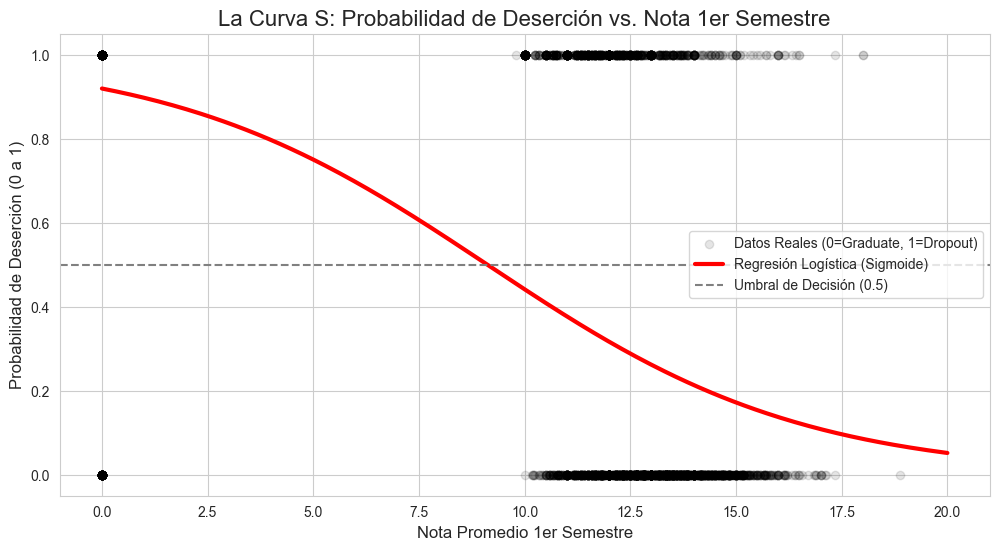

In [6]:
X_simple = df_binary[['Curricular units 1st sem (grade)']]
y = df_binary['Target_Binary']

# Entrenar modelo simple
model_simple = LogisticRegression()
model_simple.fit(X_simple, y)

# Generar predicciones de PROBABILIDAD para un rango de notas (0 a 20)
X_range = np.linspace(0, 20, 300).reshape(-1, 1)
y_prob = model_simple.predict_proba(X_range)[:, 1] # Probabilidad de clase 1 (Dropout)

# Graficar
plt.figure(figsize=(12, 6))

# 1. Los datos reales (puntos)
plt.scatter(X_simple, y, color='black', alpha=0.1, label='Datos Reales (0=Graduate, 1=Dropout)')

# 2. La curva Sigmoide (modelo)
plt.plot(X_range, y_prob, color='red', linewidth=3, label='Regresión Logística (Sigmoide)')

# Decoración
plt.axhline(0.5, color='gray', linestyle='--', label='Umbral de Decisión (0.5)')
plt.title('La Curva S: Probabilidad de Deserción vs. Nota 1er Semestre', fontsize=16)
plt.xlabel('Nota Promedio 1er Semestre', fontsize=12)
plt.ylabel('Probabilidad de Deserción (0 a 1)', fontsize=12)
plt.legend()
plt.show()

### ¿Qué estamos viendo?
1.  **La Curva S**: Fíjate cómo la línea roja nunca se sale del rango 0 a 1. A medida que la nota baja (izquierda), la probabilidad de deserción sube casi a 1. A medida que la nota sube (derecha), la probabilidad baja a 0.
2.  **Zona de Incertidumbre**: Alrededor de la nota 10-12, la curva cruza el 0.5. Ahí es donde el modelo está "indeciso".

Esta curva es generada por la fórmula matemática:
$$ P(y=1|x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x)}} $$

## 4. Desmintiendo Mitos: "¿Solo pocas variables?"
¡Falso! La Regresión Logística es muy poderosa con muchas variables. Vamos a entrenar un modelo con más datos para ver cómo "pesa" cada factor.

In [7]:
# Seleccionamos varias columnas (numéricas y categóricas ya codificadas numéricamente en este dataset)
features = [
    'Curricular units 1st sem (grade)', 
    'Age at enrollment', 
    'Tuition fees up to date', 
    'Scholarship holder', 
    'Debtor'
]

X_multi = df_binary[features]

# Dividir en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_multi, y, test_size=0.3, random_state=42)

# Entrenar
model_multi = LogisticRegression(max_iter=1000)
model_multi.fit(X_train, y_train)

# Evaluar
acc = accuracy_score(y_test, model_multi.predict(X_test))
print(f"Precisión del modelo con {len(features)} variables: {acc:.2%}")

Precisión del modelo con 5 variables: 81.73%


## 5. Interpretación: La "Caja Blanca"
Aquí es donde la Regresión Logística brilla. Podemos ver exactamente qué hace cada variable.

Los coeficientes nos dicen la relación con el **Log-Odds**. Si es positivo, aumenta el riesgo de deserción. Si es negativo, lo disminuye.

                           Variable  Coeficiente (Peso)
2           Tuition fees up to date           -2.687896
3                Scholarship holder           -1.393232
4                            Debtor            0.934699
0  Curricular units 1st sem (grade)           -0.243502
1                 Age at enrollment            0.044523


/var/folders/2q/p20x_89x4xgcp2rqzvyzpb840000gn/T/ipykernel_21897/1525229521.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Coeficiente (Peso)', y='Variable', palette='coolwarm')


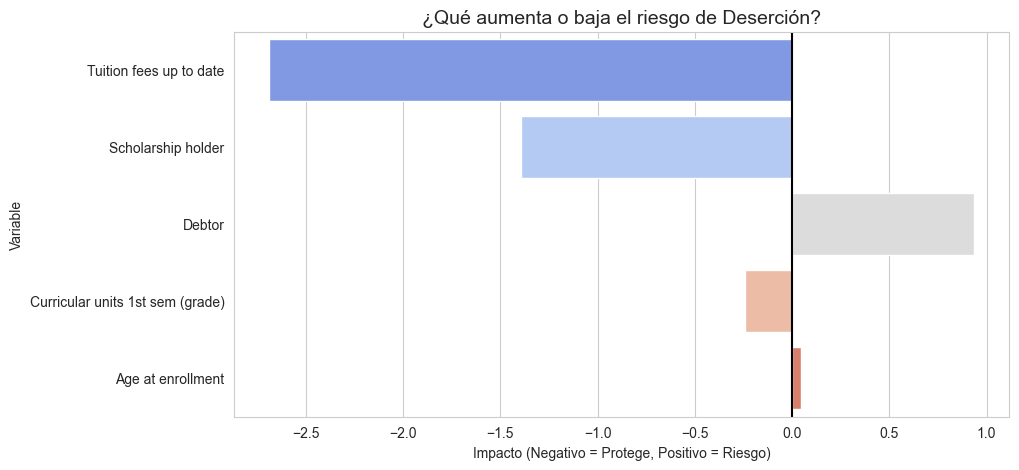

In [8]:
# Crear un DataFrame para ver los coeficientes bonitos
coef_df = pd.DataFrame({
    'Variable': features,
    'Coeficiente (Peso)': model_multi.coef_[0]
})

# Ordenar por impacto absoluto
coef_df['Impacto Absoluto'] = coef_df['Coeficiente (Peso)'].abs()
coef_df = coef_df.sort_values('Impacto Absoluto', ascending=False)

print(coef_df[['Variable', 'Coeficiente (Peso)']])

# Graficar
plt.figure(figsize=(10, 5))
sns.barplot(data=coef_df, x='Coeficiente (Peso)', y='Variable', palette='coolwarm')
plt.title('¿Qué aumenta o baja el riesgo de Deserción?', fontsize=14)
plt.xlabel('Impacto (Negativo = Protege, Positivo = Riesgo)')
plt.axvline(0, color='black', linestyle='-')
plt.show()

### Lectura de Resultados
1.  **Tuition fees up to date (Negativo)**: Tener las cuotas al día es el factor que MÁS reduce la probabilidad de deserción (barra azul grande a la izquierda).
2.  **Curricular units 1st sem (grade) (Negativo)**: Mejores notas también protegen contra la deserción.
3.  **Debtor (Positivo)**: Ser deudor aumenta el riesgo (barra roja a la derecha).
4.  **Age at enrollment (Positivo)**: A mayor edad, ligero aumento del riesgo.

Esta transparencia es por lo que la Regresión Logística sigue siendo reina en banca y medicina.